In [121]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import xgboost as xgb # The model for forecasting

In [122]:
df = pd.read_csv("train.csv")
df = df.set_index('timestamp')

In [123]:
df.index = pd.to_datetime(df.index, format='ISO8601')
df = df.sort_index()
df.head()

,starttime,endtime,machineid,batchkey,commandno,stepno,prgno,fabric_weight,command_repetition,kk_level,...,kk_irtibat_valve,slow_dosage_valve,bk_level,bk_dosage_valve,dosage_curve_type,kk_bk_common_discharge,kk_target_level,bk_target_level,kk_mikser_robotu,bk_mikser_robotu
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-08-13 04:14:50.573000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.12,...,True,False,9.61,False,0,False,0.0,0.0,False,False
2025-08-13 04:14:51.572000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.19,...,True,False,9.53,False,0,False,0.0,0.0,False,False
2025-08-13 04:14:52.572000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.12,...,True,False,9.53,False,0,False,0.0,0.0,False,False
2025-08-13 04:14:53.574000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.19,...,True,False,9.53,False,0,False,0.0,0.0,False,False
2025-08-13 04:14:54.574000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.12,...,True,False,9.53,False,0,False,0.0,0.0,False,False


In [124]:
df.tail()

,starttime,endtime,machineid,batchkey,commandno,stepno,prgno,fabric_weight,command_repetition,kk_level,...,kk_irtibat_valve,slow_dosage_valve,bk_level,bk_dosage_valve,dosage_curve_type,kk_bk_common_discharge,kk_target_level,bk_target_level,kk_mikser_robotu,bk_mikser_robotu
timestamp,,,,,,,,,,,,,,,,,,,,,
2026-02-13 03:33:06.662000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,False,False,0.0,True,0,False,0.0,1.0,False,False
2026-02-13 03:33:07.772000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,False,False,0.0,True,0,False,0.0,1.0,False,False
2026-02-13 03:33:08.884000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,False,False,0.0,True,0,False,0.0,1.0,False,False
2026-02-13 03:33:09.995000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,False,False,0.0,True,0,False,0.0,1.0,False,False
2026-02-13 03:33:11.105000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,False,False,0.0,False,0,False,0.0,1.0,False,False


In [125]:
df.columns

Index(['starttime', 'endtime', 'machineid', 'batchkey', 'commandno', 'stepno',
       'prgno', 'fabric_weight', 'command_repetition', 'kk_level',
       'bk_irtibat_valve', 'fast_dosage_valve', 'ak_level', 'kk_dosage_valve',
       'kk_irtibat_valve', 'slow_dosage_valve', 'bk_level', 'bk_dosage_valve',
       'dosage_curve_type', 'kk_bk_common_discharge', 'kk_target_level',
       'bk_target_level', 'kk_mikser_robotu', 'bk_mikser_robotu'],
      dtype='str')

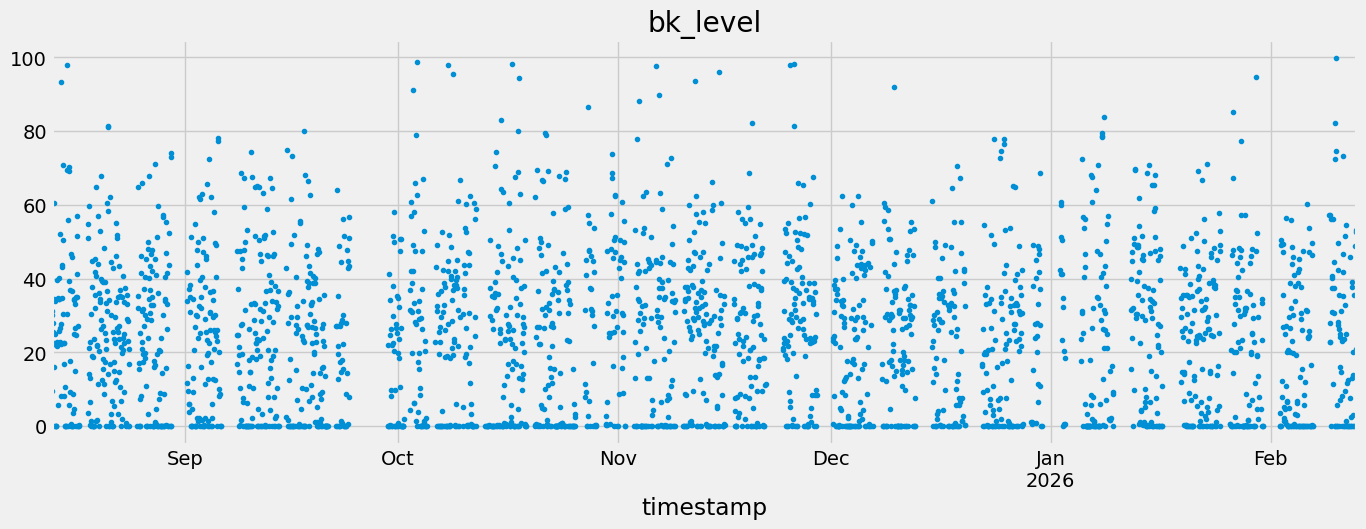

In [126]:
df_resampled = df['bk_level'].resample('1h').mean()

df_resampled.plot(style='.', 
                  figsize=(15, 5), 
                  color=color_pal[0], 
                  title='bk_level')

plt.show()

# Feature Creation

In [127]:
df.index

DatetimeIndex(['2025-08-13 04:14:50.573000+00:00',
               '2025-08-13 04:14:51.572000+00:00',
               '2025-08-13 04:14:52.572000+00:00',
               '2025-08-13 04:14:53.574000+00:00',
               '2025-08-13 04:14:54.574000+00:00',
               '2025-08-13 04:14:55.577000+00:00',
               '2025-08-13 04:14:56.575000+00:00',
               '2025-08-13 04:14:57.574000+00:00',
               '2025-08-13 04:14:58.575000+00:00',
               '2025-08-13 04:14:59.575000+00:00',
               ...
               '2026-02-13 03:33:01.105000+00:00',
               '2026-02-13 03:33:02.222000+00:00',
               '2026-02-13 03:33:03.327000+00:00',
               '2026-02-13 03:33:04.438000+00:00',
               '2026-02-13 03:33:05.549000+00:00',
               '2026-02-13 03:33:06.662000+00:00',
               '2026-02-13 03:33:07.772000+00:00',
               '2026-02-13 03:33:08.884000+00:00',
               '2026-02-13 03:33:09.995000+00:00',
            

In [128]:
df.columns

Index(['starttime', 'endtime', 'machineid', 'batchkey', 'commandno', 'stepno',
       'prgno', 'fabric_weight', 'command_repetition', 'kk_level',
       'bk_irtibat_valve', 'fast_dosage_valve', 'ak_level', 'kk_dosage_valve',
       'kk_irtibat_valve', 'slow_dosage_valve', 'bk_level', 'bk_dosage_valve',
       'dosage_curve_type', 'kk_bk_common_discharge', 'kk_target_level',
       'bk_target_level', 'kk_mikser_robotu', 'bk_mikser_robotu'],
      dtype='str')

In [129]:
def create_features(df):
    df = df.copy()
    # Create elapsed_time column
    df['starttime'] = pd.to_datetime(df['starttime'], format='ISO8601')
    df['endtime'] = pd.to_datetime(df['endtime'], format='ISO8601')
    df['elapsed_time'] = df['endtime'] - df['starttime']
    df['elapsed_time'] = df['elapsed_time'].dt.total_seconds()

    return df

df = create_features(df)

In [130]:
df.columns

Index(['starttime', 'endtime', 'machineid', 'batchkey', 'commandno', 'stepno',
       'prgno', 'fabric_weight', 'command_repetition', 'kk_level',
       'bk_irtibat_valve', 'fast_dosage_valve', 'ak_level', 'kk_dosage_valve',
       'kk_irtibat_valve', 'slow_dosage_valve', 'bk_level', 'bk_dosage_valve',
       'dosage_curve_type', 'kk_bk_common_discharge', 'kk_target_level',
       'bk_target_level', 'kk_mikser_robotu', 'bk_mikser_robotu',
       'elapsed_time'],
      dtype='str')

# Visualize our Feature / Target Relationship

In [131]:
fig, ax = plt.subplots(figsize=(150, 50))
sns.boxplot(data=df, x='batchkey', y='bk_level')
plt.show()

# Time Series Cross Validation

In [132]:
from sklearn.model_selection import GroupKFold

In [133]:
test_csv = pd.read_csv("test.csv")
test_csv

,ztimestamp,starttime,endtime,machineid,batchkey,commandno,stepno,prgno,fabric_weight,command_repetition,...,kk_irtibat_valve,slow_dosage_valve,bk_dosage_valve,dosage_curve_type,kk_bk_common_discharge,kk_target_level,bk_target_level,kk_mikser_robotu,bk_mikser_robotu,row_id
0,2025-08-13 01:30:26.400000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,...,False,False,True,0,False,0.0,18.57,False,False,0
1,2025-08-13 01:30:27.387000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,...,False,False,True,0,False,0.0,18.50,False,False,1
2,2025-08-13 01:30:28.387000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,...,False,False,True,0,False,0.0,18.42,False,False,2
3,2025-08-13 01:30:29.390000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,...,False,True,True,0,False,0.0,18.35,False,False,3
4,2025-08-13 01:30:30.390000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,...,False,False,True,0,False,0.0,18.28,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635128,2026-02-13 01:13:33.635000+00:00,2026-02-13 04:12:44,2026-02-13 04:13:39,243,144175,19,20,1080,200,0,...,True,False,False,0,False,0.0,0.00,False,False,635128
635129,2026-02-13 01:13:34.747000+00:00,2026-02-13 04:12:44,2026-02-13 04:13:39,243,144175,19,20,1080,200,0,...,True,False,False,0,False,0.0,0.00,False,False,635129
635130,2026-02-13 01:13:35.859000+00:00,2026-02-13 04:12:44,2026-02-13 04:13:39,243,144175,19,20,1080,200,0,...,True,False,False,0,False,0.0,0.00,False,False,635130
635131,2026-02-13 01:13:36.970000+00:00,2026-02-13 04:12:44,2026-02-13 04:13:39,243,144175,19,20,1080,200,0,...,True,False,False,0,False,0.0,0.00,False,False,635131


In [134]:
train = create_features(df)
gkf = GroupKFold(n_splits=5)
df= df.sort_index()

# Lag Features

In [135]:
df['bk_target_level']

timestamp
2025-08-13 04:14:50.573000+00:00    0.0
2025-08-13 04:14:51.572000+00:00    0.0
2025-08-13 04:14:52.572000+00:00    0.0
2025-08-13 04:14:53.574000+00:00    0.0
2025-08-13 04:14:54.574000+00:00    0.0
                                   ... 
2026-02-13 03:33:06.662000+00:00    1.0
2026-02-13 03:33:07.772000+00:00    1.0
2026-02-13 03:33:08.884000+00:00    1.0
2026-02-13 03:33:09.995000+00:00    1.0
2026-02-13 03:33:11.105000+00:00    1.0
Name: bk_target_level, Length: 2557652, dtype: float64

In [136]:
df['bk_dosage_valve']

timestamp
2025-08-13 04:14:50.573000+00:00    False
2025-08-13 04:14:51.572000+00:00    False
2025-08-13 04:14:52.572000+00:00    False
2025-08-13 04:14:53.574000+00:00    False
2025-08-13 04:14:54.574000+00:00    False
                                    ...  
2026-02-13 03:33:06.662000+00:00     True
2026-02-13 03:33:07.772000+00:00     True
2026-02-13 03:33:08.884000+00:00     True
2026-02-13 03:33:09.995000+00:00     True
2026-02-13 03:33:11.105000+00:00    False
Name: bk_dosage_valve, Length: 2557652, dtype: bool

In [137]:
df['dosage_curve_type']

timestamp
2025-08-13 04:14:50.573000+00:00    0
2025-08-13 04:14:51.572000+00:00    0
2025-08-13 04:14:52.572000+00:00    0
2025-08-13 04:14:53.574000+00:00    0
2025-08-13 04:14:54.574000+00:00    0
                                   ..
2026-02-13 03:33:06.662000+00:00    0
2026-02-13 03:33:07.772000+00:00    0
2026-02-13 03:33:08.884000+00:00    0
2026-02-13 03:33:09.995000+00:00    0
2026-02-13 03:33:11.105000+00:00    0
Name: dosage_curve_type, Length: 2557652, dtype: int64

In [138]:
def add_lags(df):
    df['target_lag3'] = df.groupby(['machineid', 'commandno'])['bk_target_level'].shift(3)
    df['target_lag3_diff'] = df['bk_target_level'] - df['target_lag3']
    return df

df = add_lags(df)

In [139]:
df = df.dropna(subset=["target_lag3", "target_lag3_diff"])

In [140]:
df.head()

,starttime,endtime,machineid,batchkey,commandno,stepno,prgno,fabric_weight,command_repetition,kk_level,...,bk_dosage_valve,dosage_curve_type,kk_bk_common_discharge,kk_target_level,bk_target_level,kk_mikser_robotu,bk_mikser_robotu,elapsed_time,target_lag3,target_lag3_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-08-13 04:14:53.574000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.19,...,False,0,False,0.0,0.0,False,False,58.0,0.0,0.0
2025-08-13 04:14:54.574000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.12,...,False,0,False,0.0,0.0,False,False,58.0,0.0,0.0
2025-08-13 04:14:55.577000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.19,...,False,0,False,0.0,0.0,False,False,58.0,0.0,0.0
2025-08-13 04:14:56.575000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,0.04,...,False,0,False,0.0,0.0,False,False,58.0,0.0,0.0
2025-08-13 04:14:57.574000+00:00,2025-08-13 07:14:50,2025-08-13 07:15:48,105,125450,19,2,86,485,0,2.25,...,False,0,False,0.0,0.0,False,False,58.0,0.0,0.0


In [141]:
df.tail()

,starttime,endtime,machineid,batchkey,commandno,stepno,prgno,fabric_weight,command_repetition,kk_level,...,bk_dosage_valve,dosage_curve_type,kk_bk_common_discharge,kk_target_level,bk_target_level,kk_mikser_robotu,bk_mikser_robotu,elapsed_time,target_lag3,target_lag3_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2026-02-13 03:33:06.662000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,True,0,False,0.0,1.0,False,False,676.0,1.0,0.0
2026-02-13 03:33:07.772000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,True,0,False,0.0,1.0,False,False,676.0,1.0,0.0
2026-02-13 03:33:08.884000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,True,0,False,0.0,1.0,False,False,676.0,1.0,0.0
2026-02-13 03:33:09.995000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,True,0,False,0.0,1.0,False,False,676.0,1.0,0.0
2026-02-13 03:33:11.105000+00:00,2026-02-13 06:22:56,2026-02-13 06:34:12,243,144194,22,7,1080,200,0,0.0,...,False,0,False,0.0,1.0,False,False,676.0,1.0,0.0


In [142]:
df.columns

Index(['starttime', 'endtime', 'machineid', 'batchkey', 'commandno', 'stepno',
       'prgno', 'fabric_weight', 'command_repetition', 'kk_level',
       'bk_irtibat_valve', 'fast_dosage_valve', 'ak_level', 'kk_dosage_valve',
       'kk_irtibat_valve', 'slow_dosage_valve', 'bk_level', 'bk_dosage_valve',
       'dosage_curve_type', 'kk_bk_common_discharge', 'kk_target_level',
       'bk_target_level', 'kk_mikser_robotu', 'bk_mikser_robotu',
       'elapsed_time', 'target_lag3', 'target_lag3_diff'],
      dtype='str')

In [143]:
df['proses_id'] = (df.groupby('machineid')['commandno'].diff() != 0).cumsum()

# Train Using Cross Validation

In [154]:
from sklearn.metrics import mean_absolute_error

FEATURES = ['target_lag3', 'kk_target_level', 
            'commandno', 'slow_dosage_valve', 'elapsed_time', 'stepno', 
            'kk_irtibat_valve', 'kk_dosage_valve', 'bk_target_level', 'target_lag3_diff', 
            'ak_level', 'fabric_weight', 'bk_irtibat_valve']

TARGET = 'bk_level'

gkf = GroupKFold(n_splits=5)
fold = 0
scores = []

for train_idx, val_idx in gkf.split(df, groups=df['proses_id']):
      X_train = df.iloc[train_idx][FEATURES]
      y_train = df.iloc[train_idx][TARGET]

      X_test = df.iloc[val_idx][FEATURES]
      y_test = df.iloc[val_idx][TARGET]

      print(f"fold: {fold}")
      
      reg = xgb.XGBRegressor(base_score=0.5, 
                             booster='gbtree', 
                             n_estimators=5000, 
                             objective='reg:absoluteerror',
                             max_depth=3,       
                             learning_rate=0.01,
                             tree_method='hist',
                             device='cuda') # GPU
      
      reg.fit(X_train, y_train, verbose=True)
      y_pred = reg.predict(X_test)

      score = mean_absolute_error(y_test, y_pred)
      scores.append(score)
      fold += 1  

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4


In [155]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 5.5467
Fold scores:[5.6421593561106045, 5.076306326454592, 5.826473233156366, 5.723181139555875, 5.465330505473582]


# FEATURE IMPORTANCE

In [156]:
fi = pd.DataFrame(data=reg.feature_importances_, 
                  index=reg.feature_names_in_, 
                  columns=['importance'])

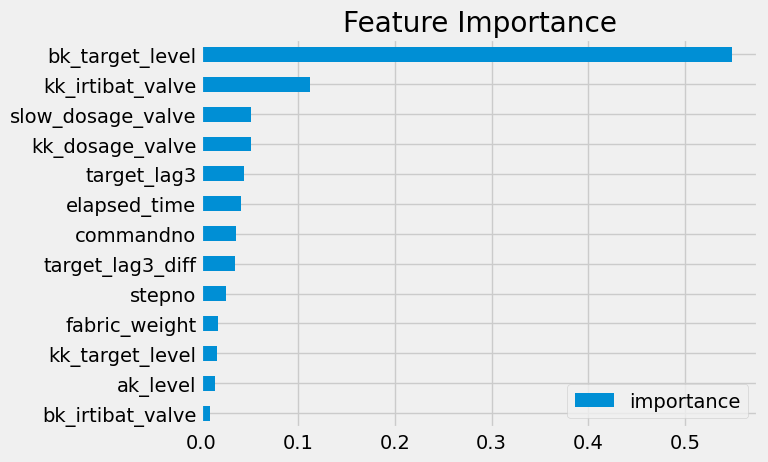

In [157]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [158]:
fi = fi.sort_values('importance')
fi

,importance
bk_irtibat_valve,0.008881
ak_level,0.014251
kk_target_level,0.016246
fabric_weight,0.016957
stepno,0.025261
target_lag3_diff,0.034440
commandno,0.035696
elapsed_time,0.041141
target_lag3,0.044435
kk_dosage_valve,0.050963


In [159]:
df.columns

Index(['starttime', 'endtime', 'machineid', 'batchkey', 'commandno', 'stepno',
       'prgno', 'fabric_weight', 'command_repetition', 'kk_level',
       'bk_irtibat_valve', 'fast_dosage_valve', 'ak_level', 'kk_dosage_valve',
       'kk_irtibat_valve', 'slow_dosage_valve', 'bk_level', 'bk_dosage_valve',
       'dosage_curve_type', 'kk_bk_common_discharge', 'kk_target_level',
       'bk_target_level', 'kk_mikser_robotu', 'bk_mikser_robotu',
       'elapsed_time', 'target_lag3', 'target_lag3_diff', 'proses_id'],
      dtype='str')

In [160]:
# Retrining
df = create_features(df)
df = add_lags(df)

FEATURES = ['target_lag3', 'kk_target_level', 
            'commandno', 'slow_dosage_valve', 'elapsed_time', 'stepno', 
            'kk_irtibat_valve', 'kk_dosage_valve', 'bk_target_level', 'target_lag3_diff', 
            'ak_level', 'fabric_weight', 'bk_irtibat_valve']
TARGET = 'bk_level'

X_all = df[FEATURES]
y_all = df[TARGET]

reg_final = xgb.XGBRegressor(base_score=0.5, 
                             booster='gbtree',    
                             n_estimators=5000, 
                             objective='reg:absoluteerror',
                             max_depth=3,
                             learning_rate=0.01,
                             tree_method='hist',
                             device='cuda') 
reg_final.fit(X_all, y_all, verbose=100)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:absoluteerror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",0.5
,booster,'gbtree'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",'cuda'
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_di

# TEST

In [161]:
test_csv = pd.read_csv("test.csv")
test_csv = test_csv.set_index('ztimestamp')
test_csv.index = pd.to_datetime(test_csv.index, format='ISO8601')
test_csv = test_csv.sort_index()

In [162]:
test_csv.head()

,starttime,endtime,machineid,batchkey,commandno,stepno,prgno,fabric_weight,command_repetition,kk_level,...,kk_irtibat_valve,slow_dosage_valve,bk_dosage_valve,dosage_curve_type,kk_bk_common_discharge,kk_target_level,bk_target_level,kk_mikser_robotu,bk_mikser_robotu,row_id
ztimestamp,,,,,,,,,,,,,,,,,,,,,
2025-08-13 01:24:30.961000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,0.12,...,False,False,False,0,False,0.0,0.0,False,False,259
2025-08-13 01:24:31.965000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,0.19,...,False,False,False,0,False,0.0,0.0,False,False,260
2025-08-13 01:24:32.962000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,0.12,...,False,False,False,0,False,0.0,0.0,False,False,261
2025-08-13 01:24:33.962000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,0.04,...,False,False,False,0,False,0.0,0.0,False,False,262
2025-08-13 01:24:34.962000+00:00,2025-08-13 04:24:30,2025-08-13 04:35:36,105,125425,22,16,1066,485,0,0.12,...,False,False,False,0,False,0.0,0.0,False,False,263


In [173]:
history_tail = df.tail(5)
test_and_history = pd.concat([history_tail, test_csv])
test_and_history = create_features(test_and_history)
test_and_history = add_lags(test_and_history)
X_test_final = test_and_history.tail(len(test_csv))[FEATURES]
test_predictions = reg_final.predict(X_test_final)

In [174]:
sample_csv = pd.read_csv("sample_submission_sample.csv")
sample_csv.head()

,row_id,bk_level
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [175]:
sample_csv['bk_level'] = test_predictions
sample_csv = sample_csv.rename(columns={'row_id' : 'Id', 'bk_level' : 'Predicted'})
sample_csv.to_csv('sample_submission.csv', index=False)

In [168]:
df1 = pd.read_csv("sample_submission.csv")
df1

,Id,Predicted,Predicted.1
0,0,48.267880,48.267880
1,1,48.267880,48.267880
2,2,48.267880,48.267880
3,3,33.175056,33.175056
4,4,33.175056,33.175056
...,...,...,...
635128,635128,6.525623,6.525623
635129,635129,6.525623,6.525623
635130,635130,6.525623,6.525623
635131,635131,6.525623,6.525623
